# 检查版本

In [1]:
from evaluate import Evaluate
evlt = Evaluate()
evlt.environment_info()

CUDA版本: 12.1
cuDNN版本: 8801
Pytorch版本: 2.2.1+cu121
显卡是否可用: 可用
显卡数量: 1
是否支持BF16数字格式: 支持
当前显卡型号: NVIDIA GeForce RTX 3070 Laptop GPU
当前显卡的CUDA算力: (8, 6)
当前显卡的总显存: 7.99951171875 GB
是否支持TensorCore: 支持
当前显卡的显存使用率: 0.0 %


# 模型训练

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import os, hashlib, csv, glob
from evaluate import Evaluate
from torch.utils.data import Dataset, DataLoader
from torch import optim
from config import Config
from unet3d import Unet3D, BalancedCrossEntropyLoss, BatchBalancedCrossEntropyLoss
from resunet3d import Res18Unet3D
from dataset import FaultData, SingleSample
from checkdata import CheckData
evlat = Evaluate()
cfg = Config()
checker = CheckData()

- 检查数据是否损坏

In [2]:
# spath = 'data/train/seis/'
# fpath = 'data/train/fault/'
# vspath = 'data/validation/seis/'
# vfpath = 'data/validation/fault/'

# # checker.generate_md5_catalog(vspath, 'dat')
# # checker.generate_md5_catalog(vfpath, 'dat')
# checker.check_files_md5(vfpath)

- 实例化模型、损失函数和优化器

In [5]:
# unet3d = Unet3D(cfg).to(cfg.device)
unet3d = Res18Unet3D(cfg).to(cfg.device)
unet3d.load_state_dict(torch.load('0best.mdl'))
optimizer = optim.Adam(unet3d.parameters(), lr=cfg.lr)
# criteon = nn.BCELoss()
# criteon = nn.CrossEntropyLoss().to(cfg.device)
# criteon = BalancedCrossEntropyLoss().to(cfg.device)
criteon = BatchBalancedCrossEntropyLoss().to(cfg.device)

In [6]:
evlat.model_structure(unet3d)

------------------------------------------------------------------------------------------
|           weight name          |               weight shape               |   number   |
------------------------------------------------------------------------------------------
| down1.0.weight                 | torch.Size([16, 1, 3, 3, 3])             | 432        |
| down1.0.bias                   | torch.Size([16])                         | 16         |
| down1.2.weight                 | torch.Size([16, 16, 3, 3, 3])            | 6912       |
| down1.2.bias                   | torch.Size([16])                         | 16         |
| down2.1.weight                 | torch.Size([32, 16, 3, 3, 3])            | 13824      |
| down2.1.bias                   | torch.Size([32])                         | 32         |
| down2.3.weight                 | torch.Size([32, 32, 3, 3, 3])            | 27648      |
| down2.3.bias                   | torch.Size([32])                         | 32         |

- 载入数据集
  - 训练集
  - 验证集

In [7]:
train_data = FaultData('train', cfg)
valid_data = FaultData('valid', cfg)
# pred_data = FaultData('pred', cfg)

initialization successful!
train data len is 800
initialization successful!
valid data len is 20


In [8]:
train_loader = DataLoader(train_data, batch_size=cfg.batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=cfg.batch_size, shuffle=True)
# pred_loader = DataLoader(pred_data, batch_size=cfg.batch_size, shuffle=False)
print('train data batch num:', len(train_loader), ', batch size is', cfg.batch_size)
print('validation data batch num:', len(valid_loader), ', batch size is', cfg.batch_size)
print(len(train_loader.dataset), len(valid_loader.dataset))

train data batch num: 100 , batch size is 8
validation data batch num: 3 , batch size is 8
800 20


- 单样本测试初始模型性能

In [10]:
# unet3d.eval()
# with torch.no_grad():
#     for x, y in valid_loader:
#         print(x.shape)
#         # x, y = x.to(cfg.device), y.to(cfg.device)
#         # y_hat = unet3d(x)
#         # # print(evlat.roc_auc(y_hat, y))
#         # # print(evlat.pr_auc(y_hat, y))
#         # print(criteon(y_hat, y).item())
#         break

- 训练过程可视化
  
  需要在命令行输入 `python -m visdom.server` 启动visdom服务器

In [11]:
import visdom

viz = visdom.Visdom(port=8089)

viz.line([0.], [0.], win='train_batch_loss', opts=dict(title='train batch loss', legend=['batch loss']))
viz.line([0.], [0.], win='train_batch_prec', opts=dict(title='train batch prec', legend=['train prec']))
viz.line([0.], [0.], win='train_batch_recal', opts=dict(title='train batch recal', legend=['train recal']))
viz.line([0.], [0.], win='train_batch_pr_auc', opts=dict(title='train batch pr auc', legend=['train pr auc']))
viz.line([0.], [0.], win='train_batch_roc_auc', opts=dict(title='train batch roc auc', legend=['train roc auc']))
viz.line([0.], [0.], win='train_epoch_loss', opts=dict(title='train epoch loss', legend=['epoch loss']))
viz.line([0.], [0.], win='validation_epoch_preci', opts=dict(title='validation epoch prec', legend=['validation prec']))
viz.line([0.], [0.], win='validation_epoch_recal', opts=dict(title='validation epoch recal', legend=['validation recal']))
viz.line([0.], [0.], win='validation_epoch_loss', opts=dict(title='validation epoch loss', legend=['validation loss']))
viz.line([0.], [0.], win='validation_epoch_pr_auc', opts=dict(title='validation epoch pr auc', legend=['validation pr auc']))
viz.line([0.], [0.], win='validation_epoch_roc_auc', opts=dict(title='validation epoch roc auc', legend=['validation roc auc']))

Setting up a new session...


'validation_epoch_roc_auc'

- 训练模型

In [12]:
global_step = 0
best_pre, best_rec, best_epoch, best_loss, best_pr_auc, best_roc_auc = 0, 0, 0, 10, 0, 0
tb_pre, tb_rec, tb_pr_auc, tb_roc_auc = 0, 0, 0, 0

In [13]:
for epoch in range(cfg.epoch):

    unet3d.train()
    for i, batch in enumerate(train_loader):

        data, label = batch
        data = data.to(cfg.device)
        label = label.to(cfg.device)

        logits = unet3d(data)
        loss = criteon(logits, label)
        train_loss = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # torch.save(unet3d.state_dict(), f'checkpoint/epoch{epoch+1}-batch{i+1}.mdl')
        global_step += 1
        print('epoch:', epoch+1, 'batch:', i+1)
        viz.line([train_loss], [global_step], win='train_batch_loss', update='append')
        
        tra_pre = evlat.precision(logits, label, cfg.threshold)
        viz.line([tra_pre], [global_step], win='train_batch_prec', update='append')

        tra_rec = evlat.recall(logits, label, cfg.threshold)
        viz.line([tra_rec], [global_step], win='train_batch_recal', update='append')

        tra_pr_auc = evlat.pr_auc(logits, label)
        viz.line([tra_pr_auc], [global_step], win='train_batch_pr_auc', update='append')

        tra_roc_auc = evlat.roc_auc(logits, label)
        viz.line([tra_roc_auc], [global_step], win='train_batch_roc_auc', update='append')

        evlat.save_data('train_batch_loss', f'epoch{epoch+1}-batch{i+1}', train_loss)
        evlat.sava_data('tra_batch_acc', 
                         f'epoch{epoch+1}-batch{i+1}', 
                         evlat.accuracy(logits, label, cfg.threshold))
        evlat.save_data('tra_batch_pre', f'epoch{epoch+1}-batch{i+1}', tra_pre)
        evlat.save_data('tra_batch_rec', f'epoch{epoch+1}-batch{i+1}', tra_rec)
        evlat.save_data('tra_batch_pr_auc', f'epoch{epoch+1}-batch{i+1}', tra_pr_auc)
        evlat.save_data('tra_batch_roc_auc', f'epoch{epoch+1}-batch{i+1}', tra_roc_auc)

        if tra_pr_auc > tb_pr_auc:
            tb_pr_auc = tra_pr_auc
            torch.save(unet3d.state_dict(), 
                       f'checkpoint/resunet/epoch{epoch+1}-batch{i+1}.mdl') 
        
        # break
    

    viz.line([train_loss], [epoch+1], win='train_epoch_loss', update='append')
    # torch.save(unet3d.state_dict(), f'checkpoint/epoch{epoch+1}.mdl')
    evlat.save_data('train_epoch_loss', f'epoch{epoch+1}', train_loss)
    evlat.save_data('tra_epoch_acc', f'epoch{epoch+1}', evlat.accuracy(logits, label, cfg.threshold))
    evlat.save_data('tra_epoch_pre', f'epoch{epoch+1}', tra_pre)
    evlat.save_data('tra_epoch_rec', f'epoch{epoch+1}', tra_rec)
    evlat.save_data('tra_epoch_pr_auc', f'epoch{epoch+1}', tra_pr_auc)
    evlat.save_data('tra_epoch_roc_auc', f'epoch{epoch+1}', tra_roc_auc)
    
    unet3d.eval()
    with torch.no_grad():

        total_acc = 0   
        total_precision = 0
        total_recall = 0
        total_loss = 0
        total_pr_auc = 0
        total_roc_auc = 0
        total_num = 0

        for x, y in valid_loader:

            x = x.to(cfg.device)
            y = y.to(cfg.device)

            y_hat = unet3d(x)
            
            total_loss += criteon(y_hat, y)
            total_acc += evlat.accuracy(y_hat, y, cfg.threshold)
            total_precision += evlat.precision(y_hat, y, cfg.threshold)
            total_recall += evlat.recall(y_hat, y, cfg.threshold)
            total_pr_auc += evlat.pr_auc(y_hat, y)
            total_roc_auc += evlat.roc_auc(y_hat, y)
            total_num += 1
            # break

        val_los = total_loss / total_num
        val_acc = total_acc / total_num
        val_pre = total_precision / total_num
        val_rec = total_recall / total_num
        val_pr_auc = evlat.pr_auc(y_hat, y)
        val_roc_auc = evlat.roc_auc(y_hat, y)

        evlat.save_data('val_epoch_los', f'epoch{epoch+1}', val_los.item())
        evlat.save_data('val_epoch_acc', f'epoch{epoch+1}', val_acc)
        evlat.save_data('val_epoch_pre', f'epoch{epoch+1}', val_pre)
        evlat.save_data('val_epoch_rec', f'epoch{epoch+1}', val_rec)
        evlat.save_data('val_epoch_pr_auc', f'epoch{epoch+1}', val_pr_auc)
        evlat.save_data('val_epoch_roc_auc', f'epoch{epoch+1}', val_roc_auc)

        if val_pr_auc > best_pr_auc:

            best_pre = val_pre
            best_rec = val_rec
            best_loss = val_los
            best_pr_auc = val_pr_auc
            best_roc_auc = val_roc_auc
            best_epoch = epoch
            torch.save(unet3d.state_dict(), 'checkpoint/resunet/best.mdl')

        viz.line([val_pre], [epoch+1], win='validation_epoch_preci', update='append')
        viz.line([val_rec], [epoch+1], win='validation_epoch_recal', update='append')
        viz.line([val_los.item()], [epoch+1], win='validation_epoch_loss', update='append')
        viz.line([val_pr_auc], [epoch+1], win='validation_epoch_pr_auc', update='append')
        viz.line([val_roc_auc], [epoch+1], win='validation_epoch_roc_auc', update='append')
    # break

# 加载模型参数
# unet3d.load_state_dict(torch.load('best.mdl'))

epoch: 1 batch: 1
epoch: 1 batch: 2
epoch: 1 batch: 3
epoch: 1 batch: 4
epoch: 1 batch: 5
epoch: 1 batch: 6
epoch: 1 batch: 7
epoch: 1 batch: 8
epoch: 1 batch: 9
epoch: 1 batch: 10
epoch: 1 batch: 11
epoch: 1 batch: 12
epoch: 1 batch: 13
epoch: 1 batch: 14
epoch: 1 batch: 15
epoch: 1 batch: 16
epoch: 1 batch: 17
epoch: 1 batch: 18
epoch: 1 batch: 19
epoch: 1 batch: 20
epoch: 1 batch: 21
epoch: 1 batch: 22
epoch: 1 batch: 23
epoch: 1 batch: 24
epoch: 1 batch: 25
epoch: 1 batch: 26
epoch: 1 batch: 27
epoch: 1 batch: 28
epoch: 1 batch: 29
epoch: 1 batch: 30
epoch: 1 batch: 31
epoch: 1 batch: 32
epoch: 1 batch: 33
epoch: 1 batch: 34
epoch: 1 batch: 35
epoch: 1 batch: 36
epoch: 1 batch: 37
epoch: 1 batch: 38
epoch: 1 batch: 39
epoch: 1 batch: 40
epoch: 1 batch: 41
epoch: 1 batch: 42
epoch: 1 batch: 43
epoch: 1 batch: 44
epoch: 1 batch: 45
epoch: 1 batch: 46
epoch: 1 batch: 47
epoch: 1 batch: 48
epoch: 1 batch: 49
epoch: 1 batch: 50
epoch: 1 batch: 51
epoch: 1 batch: 52
epoch: 1 batch: 53
ep

In [1]:
path = './data/validation/seis/'
id = 10
ss0 = SingleSample('seis', path, id, cfg).getitem().to(cfg.device)
print(ss0.shape, ss0.type())
label1 = SingleSample(
    'fault',
    './data/validation/fault/', 
    id,
    cfg).getitem().to(cfg.device)
print(label1.shape, label1.type())

NameError: name 'SingleSample' is not defined

In [19]:
unet3d.eval()
with torch.no_grad():
    pred1 = unet3d(ss0)
print(pred1.type())
# print(pred1)
# print(label1)
print(pred1.ge(0.8).sum(), label1.sum())

torch.cuda.FloatTensor
tensor(194692, device='cuda:0') tensor(156797., device='cuda:0')


In [20]:
print(pred1.shape, label1.shape)
print(evlat.accuracy(pred1, label1, 0.8))
print(evlat.precision(pred1, label1, 0.8))
print(evlat.recall(pred1, label1, 0.8))
print(evlat.pr_auc(pred1, label1))
print(evlat.roc_auc(pred1, label1))

torch.Size([1, 1, 128, 128, 128]) torch.Size([1, 1, 128, 128, 128])
0.9630780220031738
0.7038245022907977
0.8739261593015173
0.8617938768141283
0.9741812809746285


In [28]:
pred1np = evlat._flatten2np(pred1)
print(pred1np.dtype, pred1np.shape)
pred1np.tofile(f'data/pred{1}.dat')

float32 (2097152,)


# 绘图

- 载入模型

In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import os, hashlib, csv, glob
from evaluate import Evaluate
from torch.utils.data import Dataset, DataLoader
from torch import optim
from config import Config
from unet3d import Unet3D, BalancedCrossEntropyLoss, BatchBalancedCrossEntropyLoss
from resunet3d import Res18Unet3D
from dataset import FaultData, SingleSample
from checkdata import CheckData
evlat = Evaluate()
cfg = Config()
checker = CheckData()

In [6]:
unet3d = Res18Unet3D(cfg).to(cfg.device)
unet3d.load_state_dict(torch.load('checkpoint/resunet/leakyrelu/best.mdl'))
optimizer = optim.Adam(unet3d.parameters(), lr=cfg.lr)
criteon = BatchBalancedCrossEntropyLoss().to(cfg.device)

In [7]:
evlat.model_structure(unet3d)

------------------------------------------------------------------------------------------
|           weight name          |               weight shape               |   number   |
------------------------------------------------------------------------------------------
| down1.conv1.0.weight           | torch.Size([16, 1, 3, 3, 3])             | 432        |
| down1.conv1.0.bias             | torch.Size([16])                         | 16         |
| down1.conv1.1.weight           | torch.Size([16])                         | 16         |
| down1.conv1.1.bias             | torch.Size([16])                         | 16         |
| down1.conv2.0.weight           | torch.Size([16, 16, 3, 3, 3])            | 6912       |
| down1.conv2.0.bias             | torch.Size([16])                         | 16         |
| down1.conv2.1.weight           | torch.Size([16])                         | 16         |
| down1.conv2.1.bias             | torch.Size([16])                         | 16         |

In [4]:
# from torchsummary import summary

# summary(unet3d, input_size=(1,128,128,128))
evlat.model_summary(unet3d)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 16, 128, 128, 128]             448
              ReLU-2    [-1, 16, 128, 128, 128]               0
            Conv3d-3    [-1, 16, 128, 128, 128]           6,928
              ReLU-4    [-1, 16, 128, 128, 128]               0
         MaxPool3d-5       [-1, 16, 64, 64, 64]               0
            Conv3d-6       [-1, 32, 64, 64, 64]          13,856
              ReLU-7       [-1, 32, 64, 64, 64]               0
            Conv3d-8       [-1, 32, 64, 64, 64]          27,680
              ReLU-9       [-1, 32, 64, 64, 64]               0
        MaxPool3d-10       [-1, 32, 32, 32, 32]               0
           Conv3d-11       [-1, 64, 32, 32, 32]          55,360
             ReLU-12       [-1, 64, 32, 32, 32]               0
           Conv3d-13       [-1, 64, 32, 32, 32]         110,656
             ReLU-14       [-1, 64, 32,

In [8]:
# from torchstat import stat

# stat(unet3d, (1,128,128,128))

In [5]:
valid_data = FaultData('valid', cfg)
# pred_data = FaultData('pred', cfg)

initialization successful!
valid data len is 20


In [6]:
valid_loader = DataLoader(valid_data, batch_size=cfg.batch_size, shuffle=True)
# pred_loader = DataLoader(pred_data, batch_size=cfg.batch_size, shuffle=False)
print('validation data batch num:', len(valid_loader), ', batch size is', cfg.batch_size)
print(len(valid_loader.dataset))

validation data batch num: 3 , batch size is 8
20


- 效果验证

In [7]:
best_pr_auc = 0
# best_pr_auc = 1

unet3d.eval()
with torch.no_grad():

    for x, y in valid_loader:

        x = x.to(cfg.device)
        y = y.to(cfg.device)

        y_hat = unet3d(x)

        if evlat.pr_auc(y_hat, y) > best_pr_auc:
            best_pr_auc = evlat.pr_auc(y_hat, y)
            logits = y_hat
            label = y
        # break


In [8]:
print(evlat.pr_auc(logits, label))
print(evlat.roc_auc(logits, label))
# print(y.sum())

0.9076425628835083
0.9854710414443701


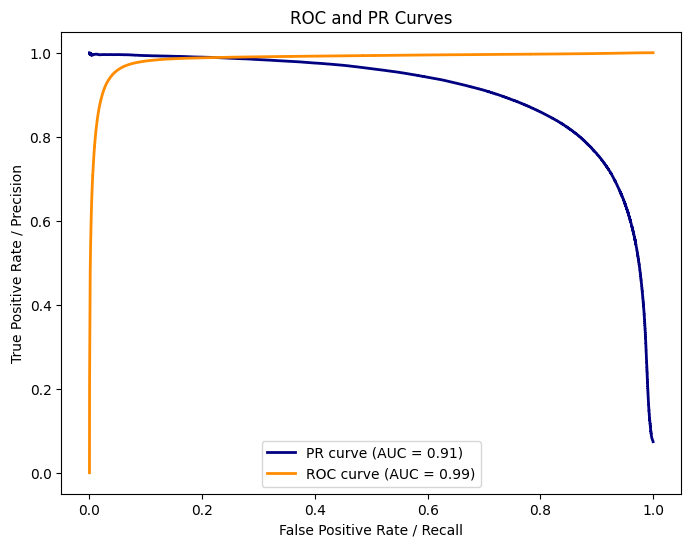

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

precision, recall, _ = evlat.pr_curve(logits, label)
fpr, tpr, _ = evlat.roc_curve(logits, label)


# for i in range(len(_)):
#     print(precision[i], recall[i], _[i])

# 计算曲线下面积（AUC）
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

# 绘制PR曲线
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='navy', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate / Recall')
plt.ylabel('True Positive Rate / Precision')
plt.title('ROC and PR Curves')
# PR
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('PR Curve')
# ROC
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curves')
# plt.legend(loc='lower right')
plt.legend(loc='lower center')
# plt.plot(recall, precision, label=f'PR Curve (AUC = {area:.2f})', color='b')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.xlabel('TPR')
# plt.ylabel('FPR')
# plt.title('ROC Curve')
# plt.legend()
plt.show()

# 切割数据

In [1]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
from sgykit import Sgykit
from generatadata import save_data

- 文件路径

In [2]:
fileName = 'data/segy/ori_slice.segy'  # 自己的路径
sgykit = Sgykit(fileName)

sgy shape is : (1301, 601, 3201)
Inline can be sliced 10 section. There are 21 remainder.
Crossline can be sliced 4 section. There are 89 remainder.
Time can be sliced 25 section. There are 1 remainder.
Blocks is 1000


In [3]:
# sgykit.data_detail(fileName)
sgykit.sgy_outline(fileName)

About 'H:/LocalDisk/project/CuanDongBei/slice1.segy'
Format type: 4-byte IEEE float
Offset count: [0]
Samples: [ 600.  601.  602. ... 3798. 3799. 3800.]
Unstructured: False
Ext_headers: 0
ilines: 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710,

In [4]:
data = sgykit.read3D(fileName)
print(type(data), data.dtype, data.shape)

<class 'numpy.ndarray'> float32 (1301, 601, 3201)


* 切割为128\*128\*128的数据

In [5]:
# path = 'H:/LocalDisk/project/CuanDongBei/slice/seis/'
path = 'data/slice/seis/'
gendb = sgykit.split_sgy(data, path, False, bias={'i': 10, 'x': 0, 't': 0})  # bias 偏移

In [6]:
print(gendb.shape)
print(gendb.min(), gendb.max())

(1280, 512, 3200)
-127.0 127.0


* 切割再重组后的数据

In [ ]:
sgykit.save_dat(gendb, 'data/slice/seis/slice_data.datt')

In [8]:
rcdb = sgykit.reconstruct_sgy(path)
print(rcdb.shape)
np.equal(rcdb, gendb).sum() == rcdb.size

# checker.check_slice_data(gendb, rcdb)

(512, 1280, 2944)


True

# 实际工区模拟

In [1]:
import torch
import numpy as np
from config import Config
from dataset import SingleSample
from unet3d import Unet3D
from resunet3d import Res18Unet3D
from checkdata import CheckData
from evaluate import Evaluate
from sgykit import Sgykit
from generatedata import save_data

In [2]:
cfg = Config()
checker = CheckData()
evlter = Evaluate()
sgykit = Sgykit()
sgset = SingleSample('seis', 'data/slice/seis/', (128, 128, 128), 1, '.dat')
unet3d = Res18Unet3D(cfg).to(cfg.device)
unet3d.load_state_dict(torch.load('checkpoint/resunet/leakyrelu/best.mdl'))

initialization successful! This folder hive 920.dat


<All keys matched successfully>

In [5]:
unet3d.eval()
with torch.no_grad():
    for i in range(sgset.fileNums):
        sgdata = sgset.getitem(i).to(cfg.device)
        pred = unet3d(sgdata)
        prednp = evlter._flatten2np(pred)
        save_data(prednp, 'data/slice/pred/resunet/leakyrelu/', f'{i}.dat')

In [6]:
redb = sgykit.reconstruct_sgy('data/slice/pred/resunet/leakyrelu/')

In [9]:
save_data(redb, 'data/slice/pred/resunet/leakyrelu/', 'predb.datt')